In [11]:
import yfinance as yf
import pandas as pd
from datetime import datetime

end_date = datetime.today().strftime('%Y-%m-%d')

# Download Bitcoin data
btc_data = yf.download('BTC-USD', start='2024-01-01', end=end_date)
btc_data = btc_data[['Close']]  # Use the closing price
btc_data.reset_index(inplace=True)

print(btc_data.head())


[*********************100%%**********************]  1 of 1 completed
        Date         Close
0 2024-01-01  44167.332031
1 2024-01-02  44957.968750
2 2024-01-03  42848.175781
3 2024-01-04  44179.921875
4 2024-01-05  44162.691406


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(btc_data['Close'].values.reshape(-1, 1))

# Create sequences of 30 days and the next day's price
sequence_length = 30
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

X = torch.tensor(X, dtype=torch.float32).unsqueeze(2)  
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: torch.Size([304, 30, 1])
y shape: torch.Size([304, 1])


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
import torch.nn as nn

class BitcoinLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(BitcoinLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])
        return out

model = BitcoinLSTM()
print(model)


BitcoinLSTM(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
model.train()

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 1/20, Loss: 0.2646
Epoch 2/20, Loss: 0.2474
Epoch 3/20, Loss: 0.2307
Epoch 4/20, Loss: 0.2144
Epoch 5/20, Loss: 0.1982
Epoch 6/20, Loss: 0.1822
Epoch 7/20, Loss: 0.1662
Epoch 8/20, Loss: 0.1501
Epoch 9/20, Loss: 0.1340
Epoch 10/20, Loss: 0.1176
Epoch 11/20, Loss: 0.1011
Epoch 12/20, Loss: 0.0845
Epoch 13/20, Loss: 0.0680
Epoch 14/20, Loss: 0.0521
Epoch 15/20, Loss: 0.0376
Epoch 16/20, Loss: 0.0260
Epoch 17/20, Loss: 0.0199
Epoch 18/20, Loss: 0.0228
Epoch 19/20, Loss: 0.0338
Epoch 20/20, Loss: 0.0416


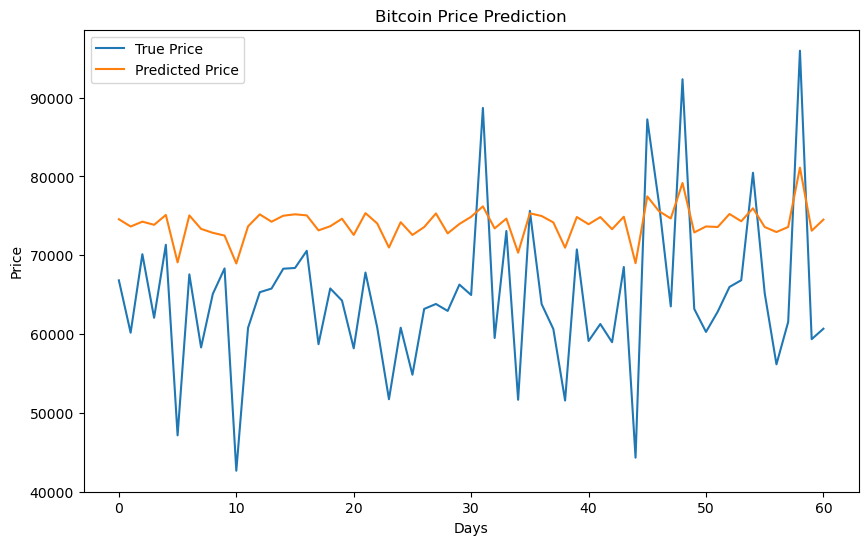

In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = scaler.inverse_transform(y_pred.numpy())
    y_test_actual = scaler.inverse_transform(y_test.numpy())

plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='True Price')
plt.plot(y_pred, label='Predicted Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
last_30_days = scaled_data[-30:] 
last_30_days = torch.tensor(last_30_days, dtype=torch.float32).reshape(1, -1, 1)
# Predict the next price
model.eval()
with torch.no_grad():
    predicted_price = model(last_30_days)
    predicted_price = scaler.inverse_transform(predicted_price.numpy())  

print(f"Predicted Bitcoin price for tomorrow: ${predicted_price[0][0]:.2f}")



Predicted Bitcoin price for tomorrow: $81380.95


In [ ]:
torch.save(model.state_dict(), 'bitcoin_lstm_model.pth')

Model saved to 'bitcoin_lstm_model.pth'
